# Evaluate Machine teaching approach
Here train on an teaching set created by reading the paersonas and scenarios.
Teachingset:

Andrea:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/ehaBtfOPDNZjzy1MEvjQmGo4Zv12_teaching_set.csv)
[Limited](../commuter/data/ehaBtfOPDNZjzy1MEvjQmGo4Zv12_teaching_set_minimal.csv)

Björn:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2_teaching_set.csv)
[Limited](../commuter/data/hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2_teaching_set_minimal.csv)

Maria:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/tnK534JMwwfhvUEycn69HPbhqkt2_teaching_set.csv)
[Limited](../commuter/data/tnK534JMwwfhvUEycn69HPbhqkt2_teaching_set_minimal.csv)



In [89]:
#Setup
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
from fastai.vision import *
sys.path.append("../code") # go to parent dir
from commuter import *
PATH="../data/"
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
procs = [FillMissing, Categorify, Normalize]
# Uncomment active user
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
personas = pd.read_csv("../data/personas.csv")
personaname = personas.loc[personas['id']==user]['name'].iloc[0]

def evaluate_teaching_daily(learner,testset):
    result = []
    #result.append(["prediction","accuracy","day"])
    for row in testset.itertuples():
        predicted = learner.predict(row)
        result.append([predicted[0],round(predicted[2].max().item(),2),row[4],row[5]])
    return (result)

### Train learner.

epoch,train_loss,valid_loss,accuracy
1,1.037314,1.324897,0.470000
2,0.636416,0.834492,0.750000
3,0.404537,0.389325,0.750000
4,0.272885,0.166955,1.000000
5,0.194158,0.064146,1.000000
6,0.142760,0.033276,1.000000
7,0.108154,0.028522,1.000000


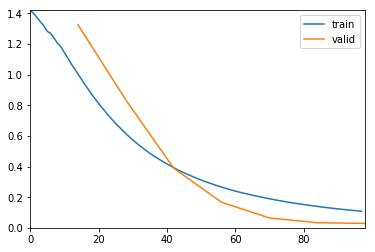

CPU times: user 1.85 s, sys: 664 ms, total: 2.51 s
Wall time: 3.13 s


In [147]:
#%%capture
teachingSetName="_teaching_set_minimal.csv"
#teachingSetName="_teaching_set.csv"
#teachingSetName="_train_valid.csv"
teachingSet = pd.read_csv(PATH+user+teachingSetName)
teachingSet= make_shure_we_got_enough_rows(teachingSet)
valid_idx = list(np.random.randint(0,len(teachingSet),int(len(teachingSet)*0.1)))
data = (TabularList.from_df(teachingSet, path=user, cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
%time learner.fit_one_cycle(7)


In [148]:
testset = pd.read_csv(PATH+user+"_start14days.csv")
result = evaluate_teaching_daily(learner,testset)
a = np.asarray(result)
print(a)
np.savetxt("saved/"+user+"_result"+teachingSetName,a,delimiter=',',fmt=["%s","%10.2f","%10.2f","%s"])

[[Category 8033880159 0.99 6 8033880159]
 [Category 8033880159 0.96 6 8033880159]
 [Category 8033880159 0.99 6 8033880159]
 [Category 8033880159 0.99 6 8033880159]
 ...
 [Category 8033880159 0.76 5 8004980338]
 [Category 8033880049 1.0 5 8004980338]
 [Category 8033880159 0.76 5 8004980338]
 [Category 8033880159 0.76 5 8004980338]]


### Check towards users test set 

In [3]:
testSet = pd.read_csv(PATH+user+"_test.csv")
result = predict_journeys(learner,testSet)
print("Test set accuracy: "+str(result))

Test set accuracy: 1.0


### Show results over the 14 first days
Prints results from training done in the cells above.

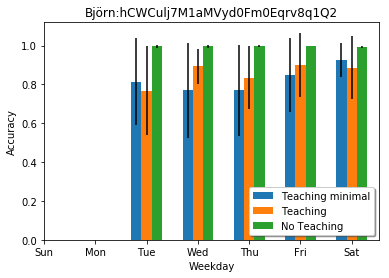

In [97]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
teaching_ax0= pd.read_csv("saved/"+user+"_result_teaching_set_minimal.csv",header=None,names=["Journey_pred", "Accuracy", "Day","Journey_corr"])
teaching_ax0_std = teaching_ax0.groupby(by="Day")["Accuracy"].std().reset_index().rename(index=str,columns=({"Accuracy":"std"}))
teaching_ax0 = teaching_ax0.groupby(by="Day")["Accuracy"].mean().reset_index()
teaching_ax1= pd.read_csv("saved/"+user+"_result_teaching_set.csv",header=None,names=["Journey", "Accuracy", "Day","Journey_corr"])
teaching_ax1_std = teaching_ax1.groupby(by="Day")["Accuracy"].std().reset_index().rename(index=str,columns=({"Accuracy":"std"}))
teaching_ax1 = teaching_ax1.groupby(by="Day")["Accuracy"].mean().reset_index()
teaching_ax2= pd.read_csv("saved/"+user+"_result_train_valid.csv",header=None,names=["Journey", "Accuracy", "Day","Journey_corr"])
teaching_ax2_std = teaching_ax2.groupby(by="Day")["Accuracy"].std().reset_index().rename(index=str,columns=({"Accuracy":"std"}))
teaching_ax2 = teaching_ax2.groupby(by="Day")["Accuracy"].mean().reset_index()
bar_width = 0.20
fig,ax0  = plt.subplots()
ax0.set_title(personaname+":"+user)
ax0.bar(teaching_ax0["Day"]-bar_width,teaching_ax0["Accuracy"],bar_width,label='Teaching minimal',yerr=teaching_ax0_std["std"])
ax0.bar(teaching_ax1["Day"],teaching_ax1["Accuracy"],bar_width, label='Teaching',yerr=teaching_ax1_std["std"])
ax0.bar(teaching_ax2["Day"]+bar_width,teaching_ax2["Accuracy"],bar_width, label='No Teaching',yerr=teaching_ax2_std["std"])
plt.xticks(np.arange(7), ("Sun","Mon","Tue","Wed","Thu","Fri","Sat"))
plt.xlabel('Weekday')
plt.ylabel('Accuracy')
legend = ax0.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

### Show results over the journeys the 14 first days
Prints results from training done in the cells above.

      Journey      mean  count       std  mean_corr  corr_value
0  8004980338  0.733143     35  0.257622   1.000000          43
1  8015980338  0.952857      7  0.007559   1.000000           7
2  8033880049  0.924118     17  0.108170   0.882353          27
3  8033880159  0.868519     27  0.165708   0.333333           9
      Journey      mean  count       std  mean_corr  corr_value
0  8004980338  0.959474     19  0.089472   1.000000          43
1  8015980338  0.970000      7  0.000000   1.000000           7
2  8033880049  0.882581     31  0.129922   0.870968          27
3  8033880159  0.826207     29  0.101363   0.310345           9
      Journey      mean  count       std  mean_corr  corr_value
0  8004980338  0.996842     38  0.004711    1.00000          43
1  8015980338  0.994286      7  0.005345    1.00000           7
2  8033880049  1.000000     32  0.000000    0.84375          27
3  8033880159  0.990000      9  0.007071    1.00000           9


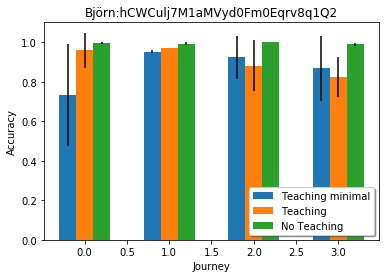

In [167]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

teaching_ax0=pd.read_csv("saved/"+user+"_result_teaching_set_minimal.csv",header=None,names=["Journey", "Accuracy", "Day","Journey_corr"])
teaching_ax0["correct"]=np.where(teaching_ax0['Journey']==teaching_ax0['Journey_corr'],1,0)
teaching_ax0_group = teaching_ax0.groupby(by="Journey")["Accuracy"].agg(['mean', 'count','std']).reset_index()
teaching_ax0_corr = teaching_ax0.groupby(by="Journey")["correct"].agg(['mean','count']).reset_index()
teaching_ax0_group["mean_corr"] = teaching_ax0_corr["mean"]
teaching_ax0_group_exists = teaching_ax0.groupby(by="Journey_corr")["Journey"].agg(['count']).reset_index()
teaching_ax0_group["corr_value"] = teaching_ax0_group_exists["count"]

#teaching_ax0["correct"]=np.where(teaching_ax0['Journey']==teaching_ax0['Journey_corr'],1,0)
#teaching_ax0_corr = teaching_ax0.groupby(by="Journey")["correct"].agg(['mean','count']).reset_index()
teaching_ax1=pd.read_csv("saved/"+user+"_result_teaching_set.csv",header=None,names=["Journey", "Accuracy", "Day","Journey_corr"])
teaching_ax1["correct"]=np.where(teaching_ax1['Journey']==teaching_ax1['Journey_corr'],1,0)
teaching_ax1_group = teaching_ax1.groupby(by="Journey")["Accuracy"].agg(['mean', 'count','std']).reset_index()
teaching_ax1_corr = teaching_ax1.groupby(by="Journey")["correct"].agg(['mean','count']).reset_index()
teaching_ax1_group["mean_corr"] = teaching_ax1_corr["mean"]
teaching_ax1_group_exists = teaching_ax1.groupby(by="Journey_corr")["Journey"].agg(['count']).reset_index()
teaching_ax1_group["corr_value"] = teaching_ax1_group_exists["count"]

teaching_ax2=pd.read_csv("saved/"+user+"_result_train_valid.csv",header=None,names=["Journey", "Accuracy", "Day","Journey_corr"])
teaching_ax2["correct"]=np.where(teaching_ax2['Journey']==teaching_ax2['Journey_corr'],1,0)
teaching_ax2_group = teaching_ax2.groupby(by="Journey")["Accuracy"].agg(['mean', 'count','std']).reset_index()
teaching_ax2_corr = teaching_ax2.groupby(by="Journey")["correct"].agg(['mean','count']).reset_index()
teaching_ax2_group["mean_corr"] = teaching_ax2_corr["mean"]
teaching_ax2_group_exists = teaching_ax2.groupby(by="Journey_corr")["Journey"].agg(['count']).reset_index()
teaching_ax2_group["corr_value"] = teaching_ax2_group_exists["count"]

print(teaching_ax0_group)
print(teaching_ax1_group)
print(teaching_ax2_group)

#teaching_ax1= pd.read_csv("saved/"+user+"_result_teaching_set.csv",header=None,names=["Journey", "Accuracy", "Day"])
#teaching_ax1_mean = teaching_ax1.groupby(by="Journey")["Accuracy"].agg(['mean', 'count']).reset_index()
#teaching_ax1_std = teaching_ax1.groupby(by="Journey")["Accuracy"].std().reset_index().rename(index=str,columns=({"Accuracy":"std"}))

# teaching_ax2= pd.read_csv("saved/"+user+"_result_train_valid.csv",header=None,names=["Journey", "Accuracy", "Day"])
# teaching_ax2_std = teaching_ax2.groupby(by="Day")["Accuracy"].std().reset_index().rename(index=str,columns=({"Accuracy":"std"}))

bar_width = 0.20
fig,ax0  = plt.subplots()
ax0.set_title(personaname+":"+user)
ax0.bar(teaching_ax0_group.index-bar_width,teaching_ax0_group["mean"],bar_width,label='Teaching minimal',yerr=teaching_ax0_group["std"])
ax0.bar(teaching_ax1_group.index,teaching_ax1_group["mean"],bar_width, label='Teaching',yerr=teaching_ax1_group["std"])
ax0.bar(teaching_ax2_group.index+bar_width,teaching_ax2_group["mean"],bar_width, label='No Teaching',yerr=teaching_ax2_group["std"])
# plt.xticks(np.arange(7), ("Sun","Mon","Tue","Wed","Thu","Fri","Sat"))
plt.xlabel('Journey')
plt.ylabel('Accuracy')
legend = ax0.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()


##Mean corr cant be correct????

#### Predict on scenarios

In [7]:
scenario_1_df = pd.read_csv(PATH+user+"_scenario_1.csv")
scenario_1_predicted = learner.predict(scenario_1_df.iloc[0])
scenario_2_df = pd.read_csv(PATH+user+"_scenario_2.csv")
scenario_2_predicted = learner.predict(scenario_2_df.iloc[0])
scenario_3_df = pd.read_csv(PATH+user+"_scenario_3.csv")
scenario_3_predicted = learner.predict(scenario_3_df.iloc[0])
print("Scenario 1 for "+personaname+" (predicted:correct) "+str(scenario_1_predicted[0])+":"+str(scenario_1_df.iloc[0].journey))
print("Scenario 2 for "+personaname+" (predicted:correct) "+str(scenario_2_predicted[0])+":"+str(scenario_2_df.iloc[0].journey))
print("Scenario 3 for "+personaname+" (predicted:correct) "+str(scenario_3_predicted[0])+":"+str(scenario_3_df.iloc[0].journey))

Scenario 1 for Björn (predicted:correct) 8033880049:8033880049
Scenario 2 for Björn (predicted:correct) 8033880159:8033880159
Scenario 3 for Björn (predicted:correct) 8004980338:8004980338


### Misc

In [18]:
the14FirstDays = pd.read_csv(PATH+user+"_start14days.csv")
result = evaluate_teaching_daily(learner,the14FirstDays)
resultAverage = predict_journeys(learner,the14FirstDays)
print("Teaching set accuracy: "+str(resultAverage))
print(result)
save_results(user+"_result_teaching_14days.csv",result)

Teaching set accuracy: 0.8488372093023255
[[1.0, 6], [0, 0], [0, 1], [1.0, 2], [1.0, 3], [1.0, 4], [0.5, 5], [1.0, 6], [0, 0], [0, 1], [1.0, 2], [1.0, 3], [0.727, 4], [0.0, 5]]
